## Import Libraries

In [123]:
!pip install scanpy
!pip3 install leidenalg
!pip3 install igraph
!pip install anndata
!pip install harmonypy

In [124]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as an
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

## Load Data

In [ ]:
# retrieve data from GEO, then decompress files
!wget -O GSM3746212_Muscle_1_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746212&format=file&file=GSM3746212%5FMuscle%5F1%5FCounts%2Ecsv%2Egz'
!gunzip GSM3746212_Muscle_1_Counts.csv.gz

!wget -O GSM3746213_Muscle_2_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746213&format=file&file=GSM3746213%5FMuscle%5F2%5FCounts%2Ecsv%2Egz'
!gunzip GSM3746213_Muscle_2_Counts.csv.gz

!wget -O GSM3746214_Muscle_3_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746214&format=file&file=GSM3746214%5FMuscle%5F3%5FCounts%2Ecsv%2Egz'
!gunzip GSM3746214_Muscle_3_Counts.csv.gz

!wget -O GSM3746215_Muscle_4_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746215&format=file&file=GSM3746215%5FMuscle%5F4%5FCounts%2Ecsv%2Egz'
!gunzip GSM3746215_Muscle_4_Counts.csv.gz

--2024-07-28 16:51:59--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746212&format=file&file=GSM3746212%5FMuscle%5F1%5FCounts%2Ecsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1169603 (1.1M) [application/octet-stream]
Saving to: ‘GSM3746212_Muscle_1_Counts.csv.gz’

GSM3746212_Muscle_1 100%[===================>]   1.12M  --.-KB/s    in 0.09s   

2024-07-28 16:51:59 (12.6 MB/s) - ‘GSM3746212_Muscle_1_Counts.csv.gz’ saved [1169603/1169603]

--2024-07-28 16:51:59--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746213&format=file&file=GSM3746213%5FMuscle%5F2%5FCounts%2Ecsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent

In [157]:
# convert ea/ samples associated CSV file into AnnData object
file_1 = pd.read_csv('GSM3746212_Muscle_1_Counts.csv', index_col=0)
muscle_1 = sc.AnnData(file_1)

file_2 = pd.read_csv('GSM3746213_Muscle_2_Counts.csv', index_col=0)
muscle_2 = sc.AnnData(file_2)

file_3 = pd.read_csv('GSM3746214_Muscle_3_Counts.csv', index_col=0)
muscle_3 = sc.AnnData(file_3)

file_4 = pd.read_csv('GSM3746215_Muscle_4_Counts.csv', index_col=0)
muscle_4 = sc.AnnData(file_4)

# create list of AnnData objects for ea/ sample
adatas = [muscle_1, muscle_2, muscle_3, muscle_4]

# combine all AnnData objects into a single object
adata_combined = sc.concat(adatas, axis=1, label='sample', keys=['muscle_1', 'muscle_2', 'muscle_3', 'muscle_4'])
adata_combined.var_names_make_unique()

In [158]:
# now, i'm going to transpose my anndata object so the rows are cell IDs and the columns are genes (since this is assumed for many downstream analysis packages)
adata_transposed = sc.AnnData(adata_combined.T)
print(adata_transposed.obs_names)  # Should list cell IDs
print(adata_transposed.var_names)  # Should list gene names

Index(['1_AAACCTGCAATCCGAT', '1_AAACGGGGTCCAGTAT', '1_AAACGGGTCGGCTTGG',
       '1_AAAGATGAGCAATATG', '1_AAAGATGGTCAAAGCG', '1_AAAGTAGCAGCGTCCA',
       '1_AAATGCCAGTTTAGGA', '1_AAATGCCCACCGATAT', '1_AACACGTGTCTGGTCG',
       '1_AACACGTTCACCACCT',
       ...
       '4_TTGACTTGTGATAAGT', '4_TTGCCGTCAAGGTTCT', '4_TTGCGTCAGTGTCCAT',
       '4_TTGGAACGTCGAATCT', '4_TTGTAGGTCAGCTGGC', '4_TTGTAGGTCTCTAAGG',
       '4_TTTACTGAGACTGTAA', '4_TTTACTGTCAGCCTAA', '4_TTTCCTCAGGTGGGTT',
       '4_TTTGGTTCACTGTCGG'],
      dtype='object', length=2876)
Index(['RP11-34P13.7', 'AP006222.2', 'RP4-669L17.10', 'RP11-206L10.3',
       'RP11-206L10.2', 'RP11-206L10.9', 'LINC00115', 'FAM41C', 'SAMD11',
       'NOC2L',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1', 'AC011043.1', 'AL592183.1',
       'AL354822.1', 'KIR2DL2', 'PNRC2.1', 'SRSF10.1'],
      dtype='object', length=15406)


In [159]:
# print basic summary info
num_genes = adata_transposed.n_vars
print(f"Number of Genes: {num_genes}")

num_cells = adata_transposed.n_obs
print(f"Number of cells: {num_cells}")

Number of Genes: 15406
Number of cells: 2876


## Quality Control, Filtering, and Normalization

In [160]:
# find indices of rows (cells) with NaN values
nan_rows = np.isnan(adata_transposed.X).any(axis=1)
print(f"Number of rows with NaN values: {np.sum(nan_rows)}")

# find indices of columns (genes) with NaN values
nan_cols = np.isnan(adata_transposed.X).any(axis=0)
print(f"Number of columns with NaN values: {np.sum(nan_cols)}")

Number of rows with NaN values: 0
Number of columns with NaN values: 0


- Based on the above, we can filter genes per cell at ~250
- No filtering is needed for cells per gene, or mito content

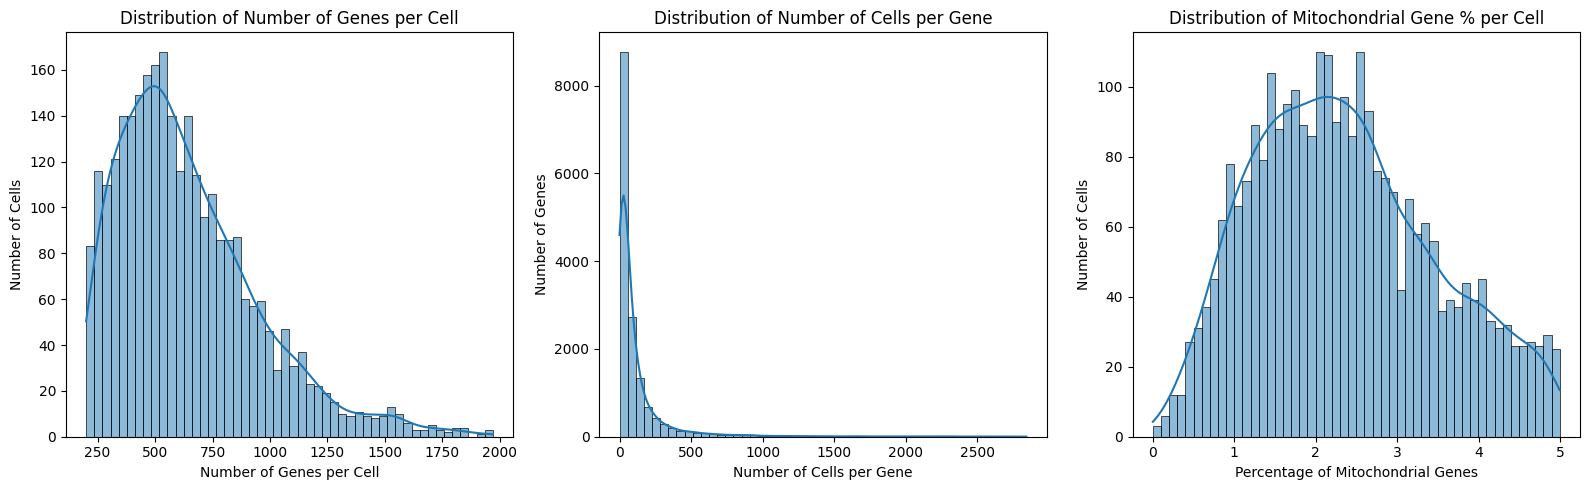

In [161]:
# calculate the # of genes per cell and cells per gene
adata_transposed.obs['n_genes'] = (adata_transposed.X > 0).sum(axis=1)
adata_transposed.var['n_cells'] = (adata_transposed.X > 0).sum(axis=0)

# identify mito genes and calculate % of mito genes per cell
mt_gene_mask = adata_transposed.var_names.str.startswith('MT-')

if isinstance(adata_transposed.X, np.ndarray):
    adata_transposed.obs['percent_mito'] = np.sum(adata_transposed[:, mt_gene_mask].X, axis=1) / np.sum(adata_transposed.X, axis=1) * 100
else:
    adata_transposed.obs['percent_mito'] = np.sum(adata_transposed[:, mt_gene_mask].X.toarray(), axis=1) / np.sum(adata_transposed.X.toarray(), axis=1) * 100

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# plot the histogram of the number of genes per cell
sns.histplot(adata_transposed.obs['n_genes'], bins=50, kde=True, ax=axes[0])
axes[0].set_xlabel('Number of Genes per Cell')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('Distribution of Number of Genes per Cell')

# plot the histogram of the number of cells per gene
sns.histplot(adata_transposed.var['n_cells'], bins=50, kde=True, ax=axes[1])
axes[1].set_xlabel('Number of Cells per Gene')
axes[1].set_ylabel('Number of Genes')
axes[1].set_title('Distribution of Number of Cells per Gene')

# plot the distribution of mito gene %
sns.histplot(adata_transposed.obs['percent_mito'], bins=50, kde=True, ax=axes[2])
axes[2].set_xlabel('Percentage of Mitochondrial Genes')
axes[2].set_ylabel('Number of Cells')
axes[2].set_title('Distribution of Mitochondrial Gene % per Cell')

plt.tight_layout()
plt.show()


In [163]:
# filter
sc.pp.filter_cells(adata_transposed, min_genes=200) #This filters out cells that have fewer than 200 detected genes
sc.pp.filter_genes(adata_transposed, min_cells=20) #This filters out genes that appear in fewer than 20 cells.

In [165]:
# print resulting number of cells and genes
num_genes = adata_transposed.n_vars
print(f"Number of Genes: {num_genes}")

num_cells = adata_transposed.n_obs
print(f"Number of cells: {num_cells}")


Number of Genes: 10485
Number of cells: 2876
AnnData object with n_obs × n_vars = 2876 × 10485
    obs: 'sample', 'n_genes', 'percent_mito'
    var: 'n_cells'


In [167]:
# global-scaling normalizatio
sc.pp.normalize_total(adata_transposed, target_sum=1e4)
sc.pp.log1p(adata_transposed)

# find the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata_transposed, n_top_genes=2000, subset=True)

print(adata_transposed)

AnnData object with n_obs × n_vars = 2876 × 2000
    obs: 'sample', 'n_genes', 'percent_mito'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


## Dimensionality reduction

In [168]:
# perform z-transformation
sc.pp.scale(adata_transposed, zero_center=True)

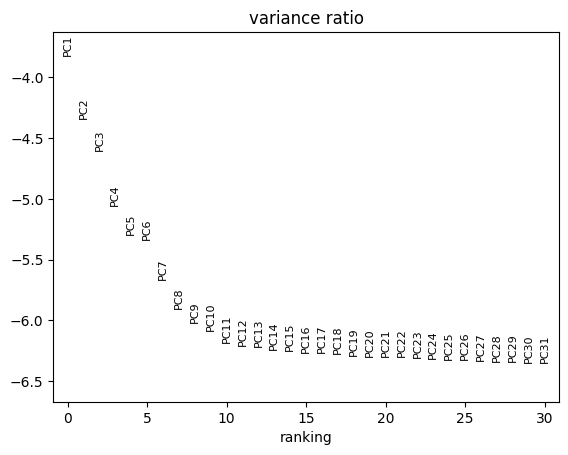

In [169]:
# perform PCA to reduce dimensionality and capture the most variance in the data.
sc.tl.pca(adata_transposed, svd_solver='arpack')

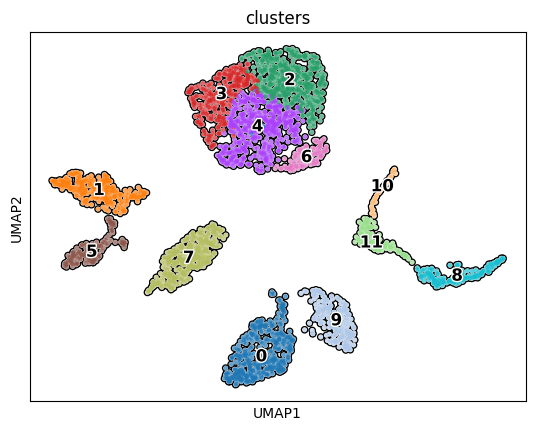

In [185]:
# determine the nearest neighbors and cluster the cells.
sc.pp.neighbors(adata_transposed, n_neighbors=10, n_pcs=10)
sc.tl.leiden(adata_transposed, key_added='clusters', resolution=0.5, n_iterations=3, flavor='igraph', directed=False)

# visualize clusters
sc.tl.umap(adata_transposed)
sc.pl.umap(adata_transposed, color='clusters', add_outline=True, legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=True)

In [186]:
# calculate silhouette score
labels = adata_transposed.obs['clusters']
sil_score = silhouette_score(adata_transposed.obsm['X_pca'], labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.15771949291229248


## Find marker genes

In [188]:
# perform differential expression analysis and find top markers for each cluster
sc.tl.rank_genes_groups(adata_transposed, groupby='clusters', method='wilcoxon', corr_method='bonferroni')
top_markers = sc.get.rank_genes_groups_df(adata_transposed, group=None)

# convert top_markers to pandas DF
top_markers_df = pd.DataFrame(top_markers)

# initialize a dictionary to store top markers
top_genes_per_cluster = {}

# gett list of clusters
clusters = adata_transposed.uns['rank_genes_groups']['names'].dtype.names

# iterate over each cluster to get top markers
for cluster in clusters:
    top_genes = top_markers_df[top_markers_df['group'] == cluster].head(3)
    top_genes_per_cluster[cluster] = top_genes

# convert dictionary to DF for easy viewing
top_genes_summary = pd.concat(top_genes_per_cluster.values(), keys=top_genes_per_cluster.keys())
print(top_genes_summary)



         group     names     scores  logfoldchanges          pvals  \
0  0         0      APOD  31.004278             NaN  4.720183e-211   
   1         0       DCN  30.380283             NaN  1.000731e-202   
   2         0       GSN  29.149391             NaN  8.504006e-187   
1  2000      1      RGS5  25.663521             NaN  2.987195e-145   
   2001      1  NDUFA4L2  23.295284             NaN  4.949157e-120   
   2002      1    IGFBP7  20.760281             NaN   9.898842e-96   
2  4000      2      AQP1  23.548231             NaN  1.308880e-122   
   4001      2       VWF  23.392542             NaN  5.089877e-121   
   4002      2       A2M  20.729593             NaN   1.873653e-95   
3  6000      3     FABP4  19.091940             NaN   2.946252e-81   
   6001      3     IFI27  16.873146             NaN   7.091765e-64   
   6002      3      CAV1  16.427576             NaN   1.214165e-60   
4  8000      4     FABP4  21.612732             NaN  1.363390e-103   
   8001      4     F

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

## identify clusters by marker gene


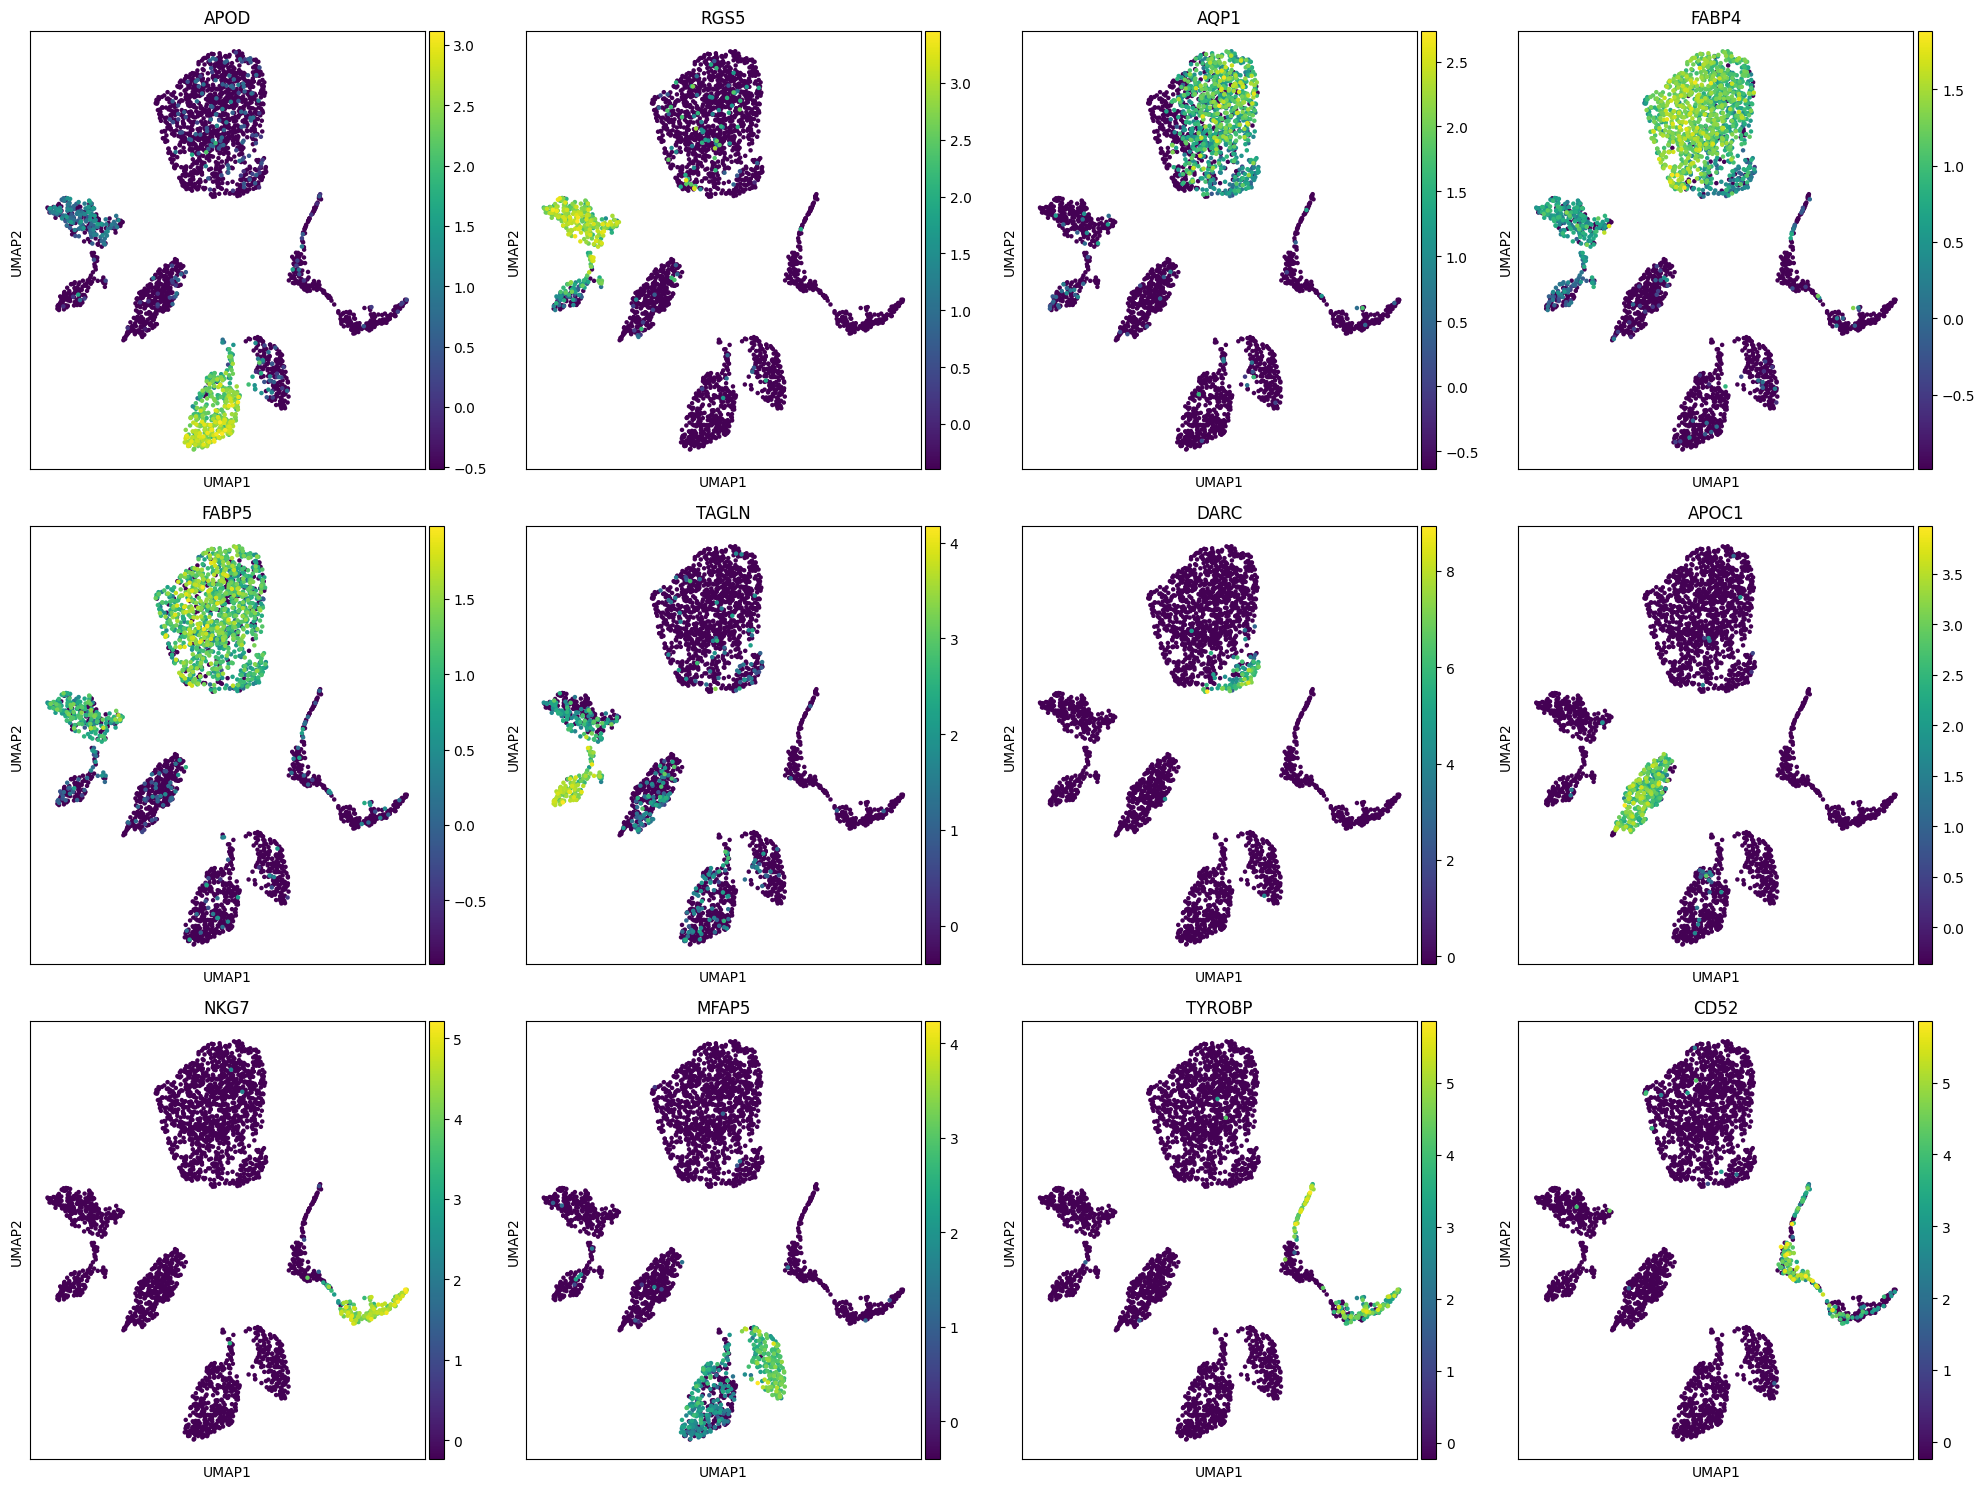

In [190]:
marker_genes = ['APOD', 'RGS5', 'AQP1', 'FABP4', 'FABP5', 'TAGLN', 'DARC', 'APOC1', 'NKG7', 'MFAP5', 'TYROBP', 'CD52']

# Plot UMAP for each marker gene
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()

for i, gene in enumerate(marker_genes):
    if gene in adata_transposed.var_names:
        sc.pl.umap(adata_transposed, color=gene, ax=axes[i], title=gene, show=False)
    else:
        axes[i].set_title(f"{gene} not in dataset")
        axes[i].axis('off')

plt.tight_layout()
plt.show()
